# Stochastic Gradient and Coordinate Descent

## Loading and preparing data

**Load the already familiar *Advertising.csv* file as a DataFrame object.** 

In [249]:
import numpy as np
import pandas as pd
import plotly.express as px

df = pd.read_csv('../../data/Advertising.csv', index_col=0)
df

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9
...,...,...,...,...
196,38.2,3.7,13.8,7.6
197,94.2,4.9,8.1,9.7
198,177.0,9.3,6.4,12.8
199,283.6,42.0,66.2,25.5


**Check if there are empty values in the data and if there are, remove them**

In [250]:
df.isnull().sum()

TV           0
radio        0
newspaper    0
sales        0
dtype: int64

> **Conclusion:**
> 
> There are no empty values in the dataset.

**Convert your features into NumPy arrays and split them into X (predictors) and y (target) variables**

In [251]:
X = np.array(df.drop('sales', axis=1))
y = np.array(df['sales'])

## Coordinate descent

**Let's add a ones column so that we have a free coefficient in the regression equation:**

In [252]:
X = np.hstack([np.ones(X.shape[0]).reshape(-1, 1), X])
y = y.reshape(-1, 1)
print(X.shape, y.shape)

(200, 4) (200, 1)


**Normalize the data: this is necessary for the algorithm to work correctly**

In [253]:
X = X / np.sqrt(np.sum(np.square(X), axis=0))

**Implement the coordinate descent algorithm:**

**Given:**

* $X=(x_{ij})$ - observation matrix, with dimension $dim(X)=(m, n)$
* $N=1000$ - number of iterations

**Note:** *1000 iterations are specified here for this task, in reality there may be a different number, there is no deterministic value.*

**Algorithm (mathematical notation):**
* Create a zero vector of parameters $w_0=(0, 0,..., 0)^T$
* For all $t=1, 2, ..., N$ iterations:
    * For all $k = 1, 2,..., n$:
        * Fix the value of all features except the $k$-th and calculate the forecast of the linear regression model. To do this, exclude the $k$-th feature from the data and $w_j$ from the parameters when constructing the forecast.
        Mathematically, this can be written as follows:

        $$h_i = \sum_{j=1}^{k-1} x_{ij}w_{j} + \sum_{j=k+1}^{n} x_{ij}w_j $$

        **Note:**

        *Note that in this entry, the current feature number $k$ is not included in the sum. Compare this entry with the classic linear regression prediction entry in the case of normalized data (when all features are included):*

        $$h_i = \sum_{j=1}^{n} x_{ij}w_{j}$$

        * Calculate the new value of the $k$-th coefficient parameter:
        $$w_k = \sum_{i=1}^{m} x_{ik} (y_i - h_i) = x_k^T(y-h) $$

    * Calculate the value of the loss function and save it in history of the loss function change (All features are involved in the loss function evaluation):
        $$\hat{y_i} = \sum_{j=1}^{n}x_{ij}w_j$$
        $$Loss_t = \frac{1}{n} \sum_{i=1}^{m}(y_i-\hat{y_i})^2$$

        or in vector form:

        $$\hat{y} = Xw$$
        $$Loss_t = \frac{1}{n}(y-\hat{y})^T(y-\hat{y})$$

You need to implement coordinate descent and infer weights in a linear regression model.

In [254]:
num_iters = 1000
m = X.shape[0]
n = X.shape[1]
w = np.zeros(n).reshape(-1, 1)

for i in range(num_iters):
    for k in range(n):
        h = (X[:,0:k]@w[0:k]) + (X[:,k+1:]@w[k+1:])
        w[k] = (X[:,k].T@(y - h))
        cost = sum(((X@w) - y)**2)/n

print('Weights of the linear regression model: ')
print(w)

Weights of the linear regression model: 
[[ 41.56217205]
 [110.13144155]
 [ 73.52860638]
 [ -0.55006384]]


Compare the results with the linear regression implementation from the sklearn library:

In [255]:
from sklearn.linear_model import LinearRegression
 
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
 
print(model.coef_)

[[ 41.56217205 110.13144155  73.52860638  -0.55006384]]


> **Conclusion:**
> 
> The results of the coordinate descent calculation are matching the results of the sklearn library.

## Stochastic Gradient Descent

**Scale the columns of the original matrix *X* (which we haven't normalized yet!). To do this, subtract the mean from each value and divide by the standard deviation**

In [256]:
def scale_column(C):
    return (C - C.mean())/C.std()


X = df.drop('sales', axis=1)

X['TV'] = scale_column(X['TV'])
X['radio'] = scale_column(X['radio'])
X['newspaper'] = scale_column(X['newspaper'])

X = np.array(X)

y = np.array(df['sales'])

**Add a ones column**

In [257]:
X = np.hstack([np.ones(X.shape[0]).reshape(-1, 1), X])

**Create a function mse_error to calculate the mean square error, taking two arguments: actual values ​​and predicted ones, and returning the mse value**

In [258]:
def mse_error(y_true, y_pred):
    n = y_true.shape[0]
    return sum((y_true - y_pred)**2)/n

**Make a naive forecast: predict sales with the mean. Then calculate the standard error for this forecast** 

In [259]:
y_pred_mean = np.array([y.mean()]*y.size)
mse_mean = mse_error(y, y_pred_mean)
print(f'MSE value for the mean forecast is: {mse_mean:.3f}')

MSE value for the mean forecast is: 27.086


**Create a function *lin_pred* that can, given a matrix of predictors *X* and a vector of linear model weights *w*, obtain a vector of predictions**

In [260]:
def lin_pred(X, w):
    return (X@w).flatten()

**Create a function *stoch_grad_step* to implement the stochastic gradient descent step.
The function must accept the following arguments:**
* matrix *X*
* vectors *y* and *w*
* parameter *train_ind* - index of the training sample object (rows of matrix *X*) by which the change in weights is calculated
* parameter *$\eta$* (eta) - gradient descent step

The result will be a vector of updated weights

A step for stochastic gradient descent looks as follows:

$$\Large w_j \leftarrow w_j - \frac{2\eta}{\ell} \sum_{i=1}^\ell{{x_{ij}((w_0 + w_1x_{i1} + w_2x_{i2} +  w_3x_{i3}) - y_i)}}$$

To write a function, you need to do the following:

* calculate the direction of change: multiply the training sample object by 2 and by the difference between the predicted value and the real one, and then divide by the number of elements in the sample.
* return the difference between the weight vector and the direction of change, multiplied by the gradient descent step

In [261]:
def stoch_grad_step(X, y, w, train_ind, eta):
    w_new = []
    diff_y = (lin_pred(X[train_ind], w) - y[train_ind])
    for j in range(X.shape[1]):
        w_new.append(w.flatten()[j] - 2*eta*sum(X[train_ind,j]*diff_y) / X.shape[0])
    return np.array(w_new)

**Create a function *stochastic_gradient_descent* to implement stochastic gradient descent**

**The function takes the following arguments as input:**
- Feature matrix X
- Target variable
- Initial point (model weights)
- Parameter defining the learning rate
- Maximum number of iterations
- Euclidean distance between weight vectors at adjacent gradient descent iterations, at which the algorithm stops working

**At each iteration, the current value of the mean square error must be written to the vector (list). The function must return the weight vector $w$, as well as the error vector (list).**

The algorithm is as follows:

* Initialize the distance between the weight vectors on adjacent iterations to a large number (infinity is possible)
* Create an empty list to record errors
* Create an iteration counter
* Implement the main training loop while the distance between the weight vectors is greater than the one at which it is necessary to stop working (when the distances become too small - it means that we are stuck in a single position) and the number of iterations is less than the maximum allowed: generate a random index, write the current error to the error vector, write the current stochastic descent step to a variable using the function written earlier. Then calculate the current distance between the weight vectors and add 1 to the iteration counter.
* Return the weight vector and the error vector

In [262]:
def stochastic_gradient_descent(X, y, w, eta, max_iter, min_dist):
    mse_list = []
    for i in range(max_iter):
        w_new = stoch_grad_step(X, y, w, np.random.randint(0, high=X.shape[0], size=None, dtype=int), eta)
        mse_list.append(mse_error(y, lin_pred(X, w_new)))
        dist = np.linalg.norm(w - w_new)
        if dist <= min_dist:
            break
        w = w_new
    return w_new, mse_list

**Run $10^5$ iterations of stochastic gradient descent. Specify an initial weight vector consisting of zeros. Feel free to experiment with the learning rate parameter.**

**Plot a graph of the error as a function of iteration number**

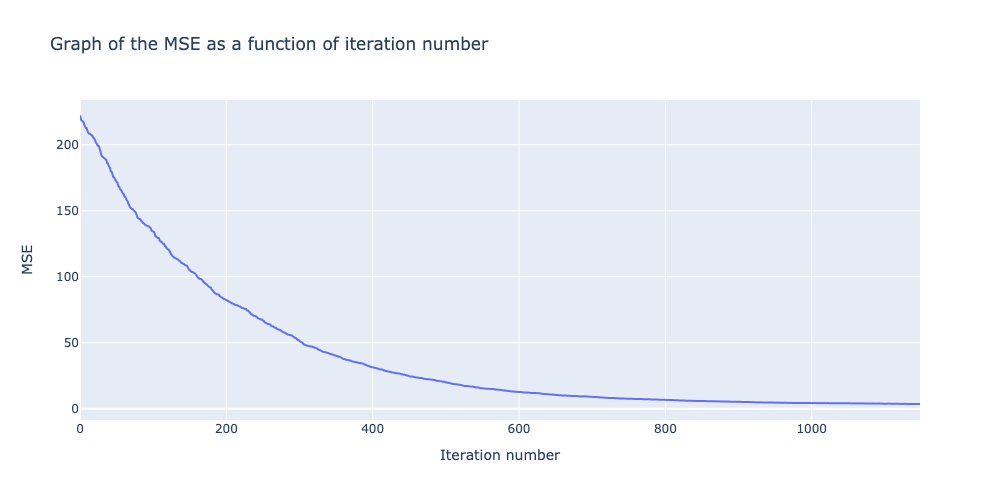

In [263]:
w_new, mse_list = stochastic_gradient_descent(X, y, np.array([0, 0, 0, 0]), 0.25, 10**5, 0.0001)

fig = px.line(
    mse_list,
    width=1000,
    height=500,
    title='Graph of the MSE as a function of iteration number'    
).update_layout(
    showlegend=False,
    yaxis_title='MSE',
    xaxis_title='Iteration number'
)
fig.show('png')

**Print the vector of weights to which the method converged.**

In [264]:
w_new

array([13.18791085,  3.66798329,  2.61252179,  0.18913293])

**Print the mean squared error at the last iteration.**

In [265]:
print(f'MSE: {mse_list[-1]:.3f} after {len(mse_list)} iterations')
 

MSE: 3.599 after 1149 iterations


> **Conclusion:**
> 
> Stochastic gradient decent is converging with the value of MSE 3.599 after 1149 iterations, which means that the distance between the weight vectors is below the specified value 0.0001. It has been achieved earlier than the defined 10^5 iterations.